In [48]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
import re

In [2]:
train_df = pd.read_csv("/Users/adarsh/Workspace/Personal/Machine-Learning-Classification/data/train.csv")
text = train_df["text"]
labels = train_df["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=101, stratify=labels)

In [4]:
tv = TfidfVectorizer()
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

In [5]:
X_train_tv_tensor = torch.tensor(X_train_tv.toarray(), dtype=torch.float32)
X_test_tv_tensor = torch.tensor(X_test_tv.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

In [6]:
X_train_tv_tensor[0].shape

torch.Size([18540])

In [7]:
train_dataset = TensorDataset(X_train_tv_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tv_tensor, y_test_tensor)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x11423f850>, <torch.utils.data.dataloader.DataLoader object at 0x11423e680>)
Length of train dataloader: 191 batches of 32
Length of test dataloader: 48 batches of 32


In [8]:
device = ("cuda"
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu")
print(f"Using device {device}")

Using device mps


In [62]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            # torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_size, out_features=5),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=5),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        logits = self.layer_stack(x)
        return logits


In [63]:
model = NeuralNetwork(input_size=18540).to(device)

In [64]:
print(model)

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Linear(in_features=18540, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [28]:
X = torch.rand(18540, device=device)

In [29]:
X.shape

torch.Size([18540])

In [30]:
logits = model(X)
pred_prob = torch.sigmoid(logits)

In [31]:
pred_prob

tensor([0.4444], device='mps:0', grad_fn=<SigmoidBackward0>)

In [32]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [33]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [34]:
torch.manual_seed(101)
epochs = 50
results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        model.train()

        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=torch.round(torch.sigmoid(y_pred)))


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)

            test_pred = model(X).squeeze()
            
            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(y_true=y, y_pred=torch.round(torch.sigmoid(test_pred)))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    if epoch % 10 == 0:
        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
    results['train_loss'].append(train_loss.detach().cpu().numpy())
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss.detach().cpu().numpy())
    results['test_acc'].append(test_acc)


  2%|▏         | 1/50 [00:00<00:28,  1.74it/s]


Train loss: 0.68336 | Test loss: 0.68308, Test acc: 57.11%



 22%|██▏       | 11/50 [00:05<00:19,  2.02it/s]


Train loss: 0.51183 | Test loss: 0.49700, Test acc: 77.38%



 42%|████▏     | 21/50 [00:10<00:14,  2.00it/s]


Train loss: 0.24491 | Test loss: 1.29440, Test acc: 51.53%



 62%|██████▏   | 31/50 [00:15<00:09,  2.02it/s]


Train loss: 0.09059 | Test loss: 0.63980, Test acc: 77.52%



 82%|████████▏ | 41/50 [00:20<00:04,  2.01it/s]


Train loss: 0.05539 | Test loss: 0.73522, Test acc: 77.19%



100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


In [35]:
torch.manual_seed(101)
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            y_pred_logit = model(X).squeeze()
            y_pred = torch.round(torch.sigmoid(y_pred_logit))

            loss += loss_fn(y_pred_logit, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred)
        
        loss /= len(dataloader)
        acc /= len(dataloader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [36]:
eval_model(model, test_dataloader, loss_fn, accuracy_fn)

{'model_name': 'NeuralNetwork',
 'model_loss': 0.8578868508338928,
 'model_acc': 77.31976425438596}

In [37]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

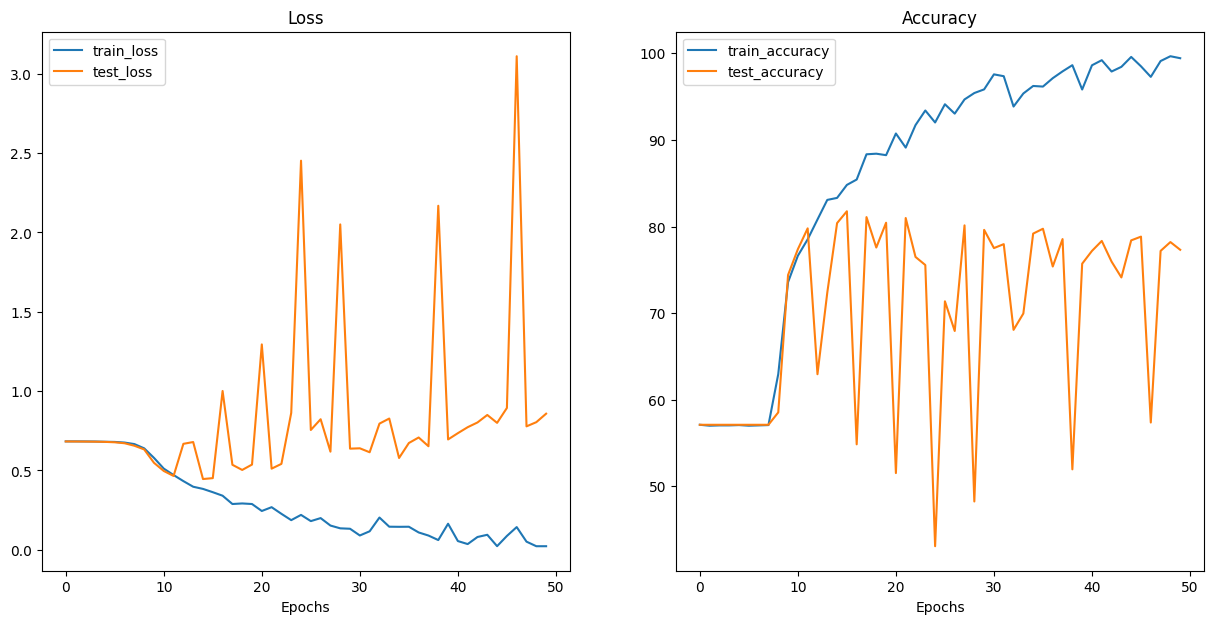

In [38]:
plot_loss_curves(results)

## GLOVE embeddings

In [44]:
def load_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding="utf-8") as f:
        for i, line in enumerate(f):
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError as e:
                print(f"Error converting line {i+1}: {line}")
                print(f"Error: {e}")
                continue
    return embeddings_index

glove_path = "/Users/adarsh/Workspace/Personal/Machine-Learning-Classification/neural_nets/glove.840B.300d.txt"
embeddings_idx = load_embeddings(glove_path)

Error converting line 52344: . . . -0.1573 -0.29517 0.30453 -0.54773 0.098293 -0.1776 0.21662 0.19261 -0.21101 0.53788 -0.047755 0.40675 0.023592 -0.32814 0.046858 0.19367 0.25565 -0.021019 -0.15957 -0.1023 0.20303 -0.043333 0.11618 -0.18486 0.0011948 -0.052301 0.34587 0.052335 0.16774 -0.21384 0.055947 0.24934 -0.12179 0.16749 0.28922 -0.033739 0.3015 -0.13241 0.092635 0.37155 -0.2884 -0.0052731 -0.001005 -0.51153 -0.28476 -0.20139 0.11837 -0.0055891 0.43604 0.16796 -0.2701 0.063957 -0.093253 -0.22079 0.36501 0.06545 0.23941 -0.19292 0.098293 0.12172 -0.1168 -0.027436 0.20507 -0.39139 -0.23111 0.46239 0.22888 -0.028415 -0.1798 0.23817 0.28093 -0.47935 0.23177 -0.35587 0.14246 0.11861 0.011018 0.091986 0.0054809 -0.39955 -0.40183 -0.10629 -0.30851 0.12383 -0.16737 -0.43569 0.4211 -0.57416 -0.19964 0.51312 0.090747 -0.21657 0.043519 0.24288 0.081134 0.49104 -0.33342 -0.31056 -0.3136 0.26931 -0.14402 0.33185 -0.21662 -0.072985 0.080603 -0.7266 -0.098385 -0.36233 -0.25346 0.1154 0.25738 0

In [45]:
for word, vec in list(embeddings_idx.items())[:5]:
    print(f"{word}: {vec[:5]}")

,: [-0.082752  0.67204  -0.14987  -0.064983  0.056491]
.: [ 0.012001  0.20751  -0.12578  -0.59325   0.12525 ]
the: [ 0.27204  -0.06203  -0.1884    0.023225 -0.018158]
and: [-0.18567   0.066008 -0.25209  -0.11725   0.26513 ]
to: [ 0.31924   0.06316  -0.27858   0.2612    0.079248]


In [47]:
# Preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = text.lower()
    return text


In [50]:
def text_to_glove(text, embeddings_idx, embedding_dim=300):
    words = word_tokenize(text)
    word_vectors = [embeddings_idx[word] for word in words if word in embeddings_idx]
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(word_vectors, axis=0)

In [52]:
train_df["cleaned_text"] = train_df["text"].apply(preprocess_text)
train_df["glove_vector"] = train_df["cleaned_text"].apply(lambda x: text_to_glove(x, embeddings_idx))

In [54]:
glove = train_df["glove_vector"]
labels = train_df["target"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(glove, labels, test_size=0.2, random_state=101, stratify=labels)

In [57]:
X_train_tensor = torch.tensor(X_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.tolist(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

/var/folders/nf/2vdf6dgx47x04v96t1hpcx9w0000gn/T/ipykernel_25012/4088563531.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_train_tensor = torch.tensor(X_train.tolist(), dtype=torch.float32)


In [60]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x42625f310>, <torch.utils.data.dataloader.DataLoader object at 0x42625de70>)
Length of train dataloader: 191 batches of 32
Length of test dataloader: 48 batches of 32


In [65]:
model_1 = NeuralNetwork(input_size=300)

In [66]:
model_1

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Linear(in_features=300, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [67]:
model_1 = model_1.to(device)

In [68]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [70]:
torch.manual_seed(101)
epochs = 50
results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        model_1.train()

        y_pred = model_1(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=torch.round(torch.sigmoid(y_pred)))


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_1.eval()
    
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)

            test_pred = model_1(X).squeeze()
            
            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(y_true=y, y_pred=torch.round(torch.sigmoid(test_pred)))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    if epoch % 10 == 0:
        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
    results['train_loss'].append(train_loss.detach().cpu().numpy())
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss.detach().cpu().numpy())
    results['test_acc'].append(test_acc)


  2%|▏         | 1/50 [00:00<00:37,  1.31it/s]


Train loss: 0.69724 | Test loss: 0.69730, Test acc: 42.89%



 22%|██▏       | 11/50 [00:04<00:14,  2.64it/s]


Train loss: 0.69717 | Test loss: 0.69730, Test acc: 42.89%



 42%|████▏     | 21/50 [00:08<00:10,  2.70it/s]


Train loss: 0.69717 | Test loss: 0.69730, Test acc: 42.89%



 62%|██████▏   | 31/50 [00:12<00:07,  2.66it/s]


Train loss: 0.69713 | Test loss: 0.69730, Test acc: 42.89%



 82%|████████▏ | 41/50 [00:15<00:03,  2.69it/s]


Train loss: 0.69720 | Test loss: 0.69730, Test acc: 42.89%



100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


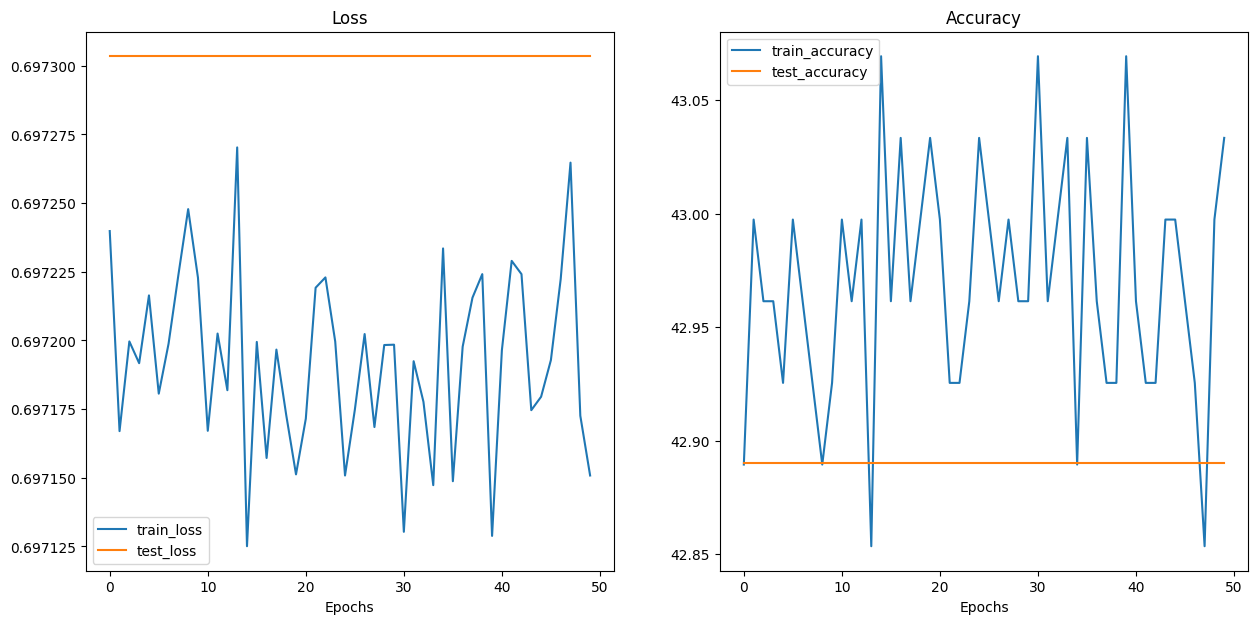

In [71]:
plot_loss_curves(results)